In [1]:
import torch
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionInpaintPipelineLegacy, DDIMScheduler, AutoencoderKL
from PIL import Image
import os
from tide import TIDE

/home/marong/linjibai/jay/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
# base_model_path = "runwayml/stable-diffusion-v1-5"
# vae_model_path = "stabilityai/sd-vae-ft-mse"
# image_encoder_path = "models/image_encoder/"
# ip_ckpt = "models/ip-adapter_sd15.bin"

base_model_path = "./models/sd1.5"
vae_model_path = "./models/sd-vae-ft-mse"
image_encoder_path = "./models/image_encoder"
ip_ckpt = './models/tide/tide_sdv1.5.bin'
output_folder = "./my_assets/output"

device = "cuda"

In [3]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)

## Image Variations

In [4]:
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)
# load SD pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

/home/marong/linjibai/jay/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a lo

In [5]:
# load tide
tide_model = TIDE(pipe, image_encoder_path, ip_ckpt, device)

bin


/home/marong/linjibai/IP/ip_adapter/ip_adapter.py:136: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(self.ip_ckpt, map_location="cpu")


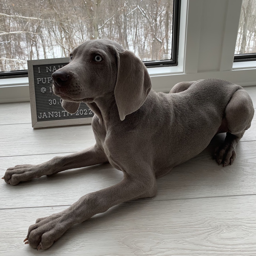

In [41]:
# read image prompt
image = Image.open("/home/marong/linjibai/IP/my_assets/6.jpeg")
# image = Image.open("/home/linjibai/IP/data/1/a photo of 1, facing to camera, best quality, ultra high res.png")
image.resize((256, 256))

In [ ]:
# generate image variations
# dressed as a gardener, tending to a vibrant flower bed, best quality, ultra high res
# climbing a mountain, facing to camera, best quality, ultra high res
# dressed as an astronaut, floating in space with Earth in the background, best quality, ultra high res
# in a superhero outfit, saving the day in a bustling city, best quality, ultra high res

# crying disappointedly, with tears flowing, facing to camera, best quality, ultra high res
# climbing a mountain, facing to camera, best quality, ultra high res
# dressed as a detective, in a foggy street, holding a magnifying glass, best quality, ultra high res
# coding in front of a computer, facing to camera, best quality, ultra high res

images = tide_model.generate(pil_image=image, num_samples=8, num_inference_steps=100, #seed=42,
                           prompt='Painting of dog at a beach by artist claude monet', 
                           scale=0.5)
grid = image_grid(images, 2, 4)
grid

## Image-to-Image

In [6]:
# load SD Img2Img pipe
del pipe, tide_model
torch.cuda.empty_cache()
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [ ]:
# read image prompt
g_image = Image.open("my_assets/image/vermeer.jpg")
image = Image.open("my_assets/image/statue.png")

image_grid([image.resize((256, 256)), g_image.resize((256, 256))], 1, 2)

In [59]:
# load ip-adapter
tide_model = TIDE(pipe, image_encoder_path, ip_ckpt, device)

bin


In [ ]:
# generate
images = tide_model.generate(pil_image=image, num_samples=4, num_inference_steps=50, image=g_image, strength=0.2) #,seed=42)
grid = image_grid(images, 1, 4)
grid